In [865]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import boxcox, yeojohnson
from matplotlib import pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, GRU, Dropout
from keras.wrappers.scikit_learn import KerasRegressor

In [866]:
df = pd.read_csv('data/processed_dataset.csv')

In [867]:
df.head()

,Date,Latitude,Longitude,Altitude,NO2,PM2.5,O3,PM10,temperature_2m (°C),relative_humidity_2m (%),...,soil_temperature_0_to_7cm (°C),soil_moisture_0_to_7cm (m³/m³),is_day (),PM2.5/N02,PM2.5/03,Weekend,Season_Autumn,Season_Spring,Season_Summer,Season_Winter
0,2023-02-15 19:35:00+00:00,46.234818,15.267305,240.0,4.248495,4.262680,0.857538,4.499810,0.5,91.0,...,0.384574,-1.055553,0.0,0.014185,4.416369,0,False,False,False,True
1,2023-02-15 20:15:00+00:00,46.234818,15.267305,240.0,4.025352,4.330733,2.000000,4.454347,0.1,92.0,...,0.195874,-1.055553,0.0,0.305382,3.637586,0,False,False,False,True
2,2023-02-15 20:35:00+00:00,46.234818,15.267305,240.0,4.025352,4.330733,2.000000,4.454347,0.1,92.0,...,0.195874,-1.055553,0.0,0.305382,3.637586,0,False,False,False,True
3,2023-02-15 21:15:00+00:00,46.234818,15.267305,240.0,3.871201,4.290459,2.000000,4.356709,-1.1,93.0,...,0.098930,-1.055553,0.0,0.419258,3.597312,0,False,False,False,True
4,2023-02-15 21:35:00+00:00,46.234818,15.267305,240.0,3.871201,4.290459,2.000000,4.356709,-1.1,93.0,...,0.098930,-1.055553,0.0,0.419258,3.597312,0,False,False,False,True


In [868]:
df.isnull().sum()

Date                              0
Latitude                          0
Longitude                         0
Altitude                          0
NO2                               0
PM2.5                             0
O3                                0
PM10                              0
temperature_2m (°C)               0
relative_humidity_2m (%)          0
dew_point_2m (°C)                 0
apparent_temperature (°C)         0
precipitation (mm)                0
rain (mm)                         0
snowfall (cm)                     0
surface_pressure (hPa)            0
cloud_cover (%)                   0
wind_speed_10m (km/h)             0
wind_direction_10m (°)            0
soil_temperature_0_to_7cm (°C)    0
soil_moisture_0_to_7cm (m³/m³)    0
is_day ()                         0
PM2.5/N02                         0
PM2.5/03                          4
Weekend                           0
Season_Autumn                     0
Season_Spring                     0
Season_Summer               

In [869]:
# delete rows with null values
df.dropna(inplace=True)

In [870]:
df.isnull().sum()

Date                              0
Latitude                          0
Longitude                         0
Altitude                          0
NO2                               0
PM2.5                             0
O3                                0
PM10                              0
temperature_2m (°C)               0
relative_humidity_2m (%)          0
dew_point_2m (°C)                 0
apparent_temperature (°C)         0
precipitation (mm)                0
rain (mm)                         0
snowfall (cm)                     0
surface_pressure (hPa)            0
cloud_cover (%)                   0
wind_speed_10m (km/h)             0
wind_direction_10m (°)            0
soil_temperature_0_to_7cm (°C)    0
soil_moisture_0_to_7cm (m³/m³)    0
is_day ()                         0
PM2.5/N02                         0
PM2.5/03                          0
Weekend                           0
Season_Autumn                     0
Season_Spring                     0
Season_Summer               

In [871]:
df.shape

(5621, 29)

In [872]:
output_col = 'PM10'

input_cols = df.columns.tolist()
input_cols.remove(output_col)
input_cols.remove('Date')

information_gain_scores = mutual_info_regression(df[input_cols], df[output_col])

feature_importances = pd.Series(information_gain_scores, index=input_cols)
feature_importances.name = 'Information Gain Scores'
feature_importances.sort_values(ascending=False, inplace=True)

feature_importances.head(10)

PM2.5                             1.516576
PM2.5/03                          0.810866
PM2.5/N02                         0.552520
soil_moisture_0_to_7cm (m³/m³)    0.508576
dew_point_2m (°C)                 0.397830
soil_temperature_0_to_7cm (°C)    0.389526
apparent_temperature (°C)         0.334459
NO2                               0.322119
temperature_2m (°C)               0.307045
O3                                0.300820
Name: Information Gain Scores, dtype: float64

In [873]:
top_features = feature_importances.head(2).index.tolist()
print(top_features)

['PM2.5', 'PM2.5/03']


In [874]:
target = "PM10"
features = top_features + [target]
dataset = df[features]

In [875]:
dataset.head()

,PM2.5,PM2.5/03,PM10
0,4.262680,4.416369,4.499810
1,4.330733,3.637586,4.454347
2,4.330733,3.637586,4.454347
3,4.290459,3.597312,4.356709
4,4.290459,3.597312,4.356709


In [876]:
dataset.shape

(5621, 3)

In [877]:
test_split = round(len(dataset) * 0.2)

In [878]:
train_data = dataset[:-1041]
test_data = dataset[-1041:]

In [879]:
print(train_data.shape, test_data.shape)

(4580, 3) (1041, 3)


In [880]:
scaler = MinMaxScaler(feature_range=(0, 1))

train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [881]:
def create_time_series(data, n_past):
    X, y = [], []
    for i in range(n_past, len(data)):
        X.append(data[i - n_past:i, 0:data.shape[1]])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [882]:
window_size = 48*7
X_train, y_train = create_time_series(train_data, window_size)
X_test, y_test = create_time_series(test_data, window_size)

In [883]:
print(X_train.shape, y_train.shape)

(4244, 336, 3) (4244,)


In [884]:
print(X_test.shape, y_test.shape)

(705, 336, 3) (705,)


In [886]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(window_size, X_train.shape[2])))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [888]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=1,
                    shuffle=False)

Epoch 1/10
67/67 [==============================] - 13s 198ms/step - loss: 0.0164 - val_loss: 0.0313
Epoch 2/10
67/67 [==============================] - 13s 191ms/step - loss: 0.0133 - val_loss: 0.0246
Epoch 3/10
67/67 [==============================] - 12s 183ms/step - loss: 0.0114 - val_loss: 0.0215
Epoch 4/10
67/67 [==============================] - 13s 194ms/step - loss: 0.0099 - val_loss: 0.0188
Epoch 5/10
67/67 [==============================] - 13s 188ms/step - loss: 0.0089 - val_loss: 0.0167
Epoch 6/10
67/67 [==============================] - 13s 186ms/step - loss: 0.0085 - val_loss: 0.0146
Epoch 7/10
67/67 [==============================] - 13s 186ms/step - loss: 0.0074 - val_loss: 0.0129
Epoch 8/10
67/67 [==============================] - 12s 184ms/step - loss: 0.0068 - val_loss: 0.0116
Epoch 9/10
67/67 [==============================] - 12s 186ms/step - loss: 0.0063 - val_loss: 0.0103
Epoch 10/10
67/67 [==============================] - 12s 186ms/step - loss: 0.0059 - val_lo

In [889]:
prediction = model.predict(X_test)

23/23 [==============================] - 1s 27ms/step


In [890]:
prediction

array([[0.47181067],
       [0.5760084 ],
       [0.6431881 ],
       [0.6801173 ],
       [0.6813472 ],
       [0.6180891 ],
       [0.5714906 ],
       [0.5149321 ],
       [0.47055793],
       [0.43724543],
       [0.4283398 ],
       [0.41008532],
       [0.39273584],
       [0.40358102],
       [0.41082802],
       [0.3945786 ],
       [0.3852424 ],
       [0.34303012],
       [0.31165585],
       [0.33304495],
       [0.37233475],
       [0.42400151],
       [0.46609744],
       [0.508599  ],
       [0.56806487],
       [0.6325154 ],
       [0.68897694],
       [0.7091894 ],
       [0.7158079 ],
       [0.7013684 ],
       [0.68725514],
       [0.6796523 ],
       [0.67579603],
       [0.66739523],
       [0.6196366 ],
       [0.56623614],
       [0.5508548 ],
       [0.60196614],
       [0.63943577],
       [0.64064676],
       [0.57410026],
       [0.46642506],
       [0.41134802],
       [0.37794557],
       [0.36209548],
       [0.34606466],
       [0.33658153],
       [0.342

In [891]:
prediction.shape

(705, 1)

In [892]:
X_test.shape

(705, 336, 3)

In [893]:
prediction_copies_array = np.repeat(prediction, 3, axis=-1)

In [894]:
prediction_copies_array.shape

(705, 3)

In [895]:
pred = scaler.inverse_transform(np.reshape(prediction_copies_array, (len(prediction), 3)))[:, 0]

In [896]:
pred.shape

(705,)

In [897]:
pred

array([2.616973  , 3.041843  , 3.3157709 , 3.466351  , 3.471366  ,
       3.2134285 , 3.0234215 , 2.792802  , 2.6118648 , 2.4760318 ,
       2.439719  , 2.3652854 , 2.2945423 , 2.338764  , 2.368314  ,
       2.3020563 , 2.2639875 , 2.0918655 , 1.9639356 , 2.0511503 ,
       2.2113562 , 2.4220293 , 2.593677  , 2.7669785 , 3.0094528 ,
       3.2722523 , 3.5024765 , 3.5848935 , 3.6118808 , 3.553003  ,
       3.4954557 , 3.4644547 , 3.4487307 , 3.4144762 , 3.2197385 ,
       3.0019963 , 2.9392784 , 3.1476867 , 3.3004704 , 3.3054082 ,
       3.0340624 , 2.595013  , 2.3704343 , 2.2342346 , 2.169605  ,
       2.104239  , 2.0655708 , 2.0883229 , 2.155265  , 2.1844518 ,
       2.1089878 , 2.007545  , 1.9332042 , 1.8707832 , 1.7841399 ,
       1.7108407 , 1.6549567 , 1.6254572 , 1.6129045 , 1.6181774 ,
       1.6819844 , 1.7634813 , 1.7952113 , 1.745602  , 1.6868814 ,
       1.5947229 , 1.3614279 , 1.1449026 , 0.996821  , 0.8919578 ,
       0.9219744 , 0.9973028 , 1.1277758 , 1.2533282 , 1.47578

In [898]:
original_copies_array = np.repeat(y_test, 3, axis=-1)
original = scaler.inverse_transform(np.reshape(original_copies_array, (len(y_test), 3)))[:, 0]

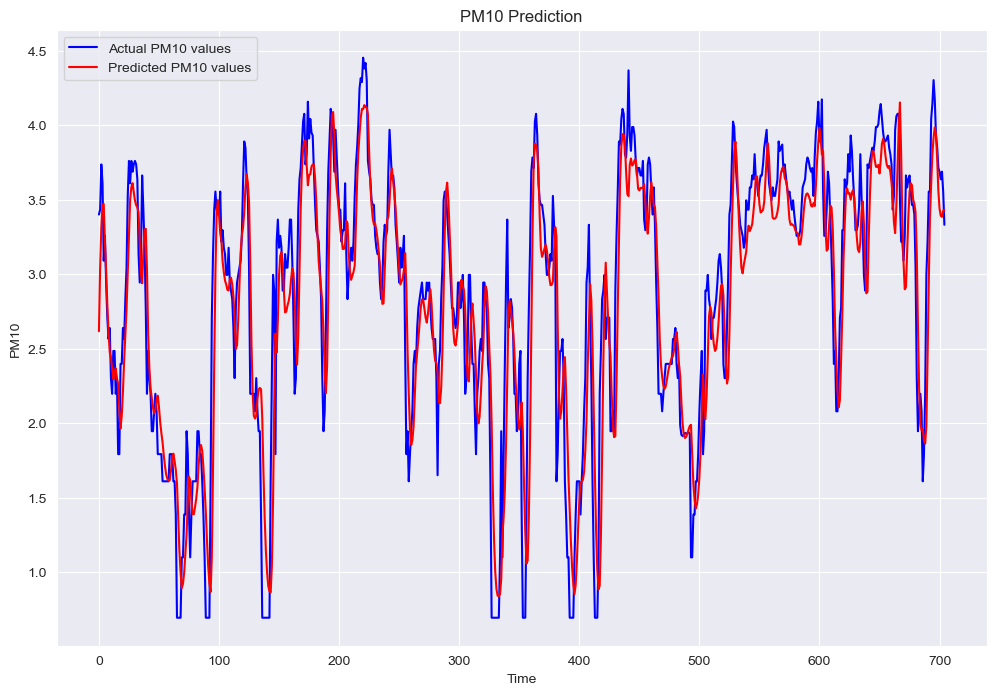

In [899]:
plt.figure(figsize=(12,8))
plt.plot(original, color='blue', label='Actual PM10 values')
plt.plot(pred, color='red', label='Predicted PM10 values')
plt.title('PM10 Prediction')
plt.xlabel('Time')
plt.ylabel('PM10')
plt.legend()
plt.show()

In [900]:
df_output = pd.DataFrame({'Actual': original, 'Predicted': pred})
df_output.head(1000)

,Actual,Predicted
0,3.401197,2.616973
1,3.433987,3.041843
2,3.737670,3.315771
3,3.610918,3.466351
4,3.091042,3.471366
...,...,...
700,3.688879,3.438087
701,3.637586,3.392341
702,3.688879,3.385476
703,3.555348,3.427126
